## NER(English)

* Title : **[Anne of green gables](http://www.gutenberg.org/ebooks/45), [The Prophet](http://www.gutenberg.org/ebooks/58585)**
* Authors: **L. M. Montgomery, Kahlil Gibran**

In [1]:
# basic libraries
import pandas as pd
import numpy as np
import string,re,os

# visualization library
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from wordcloud import WordCloud, STOPWORDS

# text processing libraries
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
import spacy
from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()

# word sense disambiguation
from pywsd import disambiguate
from pywsd.similarity import max_similarity as maxsim
import neuralcoref

Warming up PyWSD (takes ~10 secs)... took 6.085762977600098 secs.


* Referring "Anne of green gables" as Anne
* Referring "The Prophet" as prophet

# 1. Loading Data and initial Preprocessing

In [2]:
# Reading text file 'anne' (r+ mode)  
file1 = open("anne.txt","r+", errors='ignore')

# reading all lines in text of anne
text = file1.readlines() 

file1.close()

In [3]:
# Reading text file 'prophet' (r+ mode) 
file2 = open("prophet.txt","r+", errors='ignore')

# reading all lines in text of prophet
text2 = file2.readlines() 

file2.close()

In [4]:
# removing author's name, etc. from both novels
prophet = text2[114:(-371)]
anne = text[93:(-369)]

In [5]:
def initprep(text,low):
    '''
        Function to create string of list,
        followed by replacing /n[newline] tags with blank string '''
    
    g = (" ".join(text)) 
    g = g.replace("\n","")
    
    if low=='1':
        g=g.lower()
    
    return g

anne = initprep(anne,'0')
prophet = initprep(prophet,'0')

# 2. Contraction Mapping

Contraction are shortened version of words or syllables. They exist in either written or spoken
forms. By nature, contraction pose a problem for NLP and text analysis because we have a special
apostrophe character in the word. Plus we have two or more words represented by a contraction,
and this opens a whole new can of worms when we try to tokenize this or even standardize the
words.


In [6]:
contraction_mapping = {
    "'cause": 'because','â€™': "'",',cause': 'because',';cause': 'because',"ain't": 'am not','ain,t': 'am not','ain;t': 'am not',
    'ain´t': 'am not','ain’t': 'am not',"aren't": 'are not','â€“': '-','â€œ':'"','aren,t': 'are not','aren;t': 'are not',
    'aren´t': 'are not','aren’t': 'are not',"can't": 'cannot',"can't've": 'cannot have','can,t': 'cannot','can,t,ve': 'cannot have',
    'can;t': 'cannot','can;t;ve': 'cannot have','can´t': 'cannot','can´t´ve': 'cannot have','can’t': 'cannot','can’t’ve': 'cannot have',
    "could've": 'could have','could,ve': 'could have','could;ve': 'could have',"couldn't": 'could not',"couldn't've": 'could not have',
    'couldn,t': 'could not','couldn,t,ve': 'could not have','couldn;t': 'could not','couldn;t;ve': 'could not have','couldn´t': 'could not',
    'couldn´t´ve': 'could not have','couldn’t': 'could not','couldn’t’ve': 'could not have','could´ve': 'could have',
    'could’ve': 'could have',"didn't": 'did not','didn,t': 'did not','didn;t': 'did not','didn´t': 'did not','didn’t': 'did not',
    "doesn't": 'does not','doesn,t': 'does not','doesn;t': 'does not','doesn´t': 'does not','doesn’t': 'does not',"don't": 'do not',
    'don,t': 'do not','don;t': 'do not','don´t': 'do not','don’t': 'do not',"hadn't": 'had not',"hadn't've": 'had not have',
    'hadn,t': 'had not','hadn,t,ve': 'had not have','hadn;t': 'had not','hadn;t;ve': 'had not have','hadn´t': 'had not',
    'hadn´t´ve': 'had not have','hadn’t': 'had not','hadn’t’ve': 'had not have',"hasn't": 'has not','hasn,t': 'has not',
    'hasn;t': 'has not','hasn´t': 'has not','hasn’t': 'has not',"haven't": 'have not','haven,t': 'have not','haven;t': 'have not',
    'haven´t': 'have not','haven’t': 'have not',"he'd": 'he would',"he'd've": 'he would have',"he'll": 'he will',
    "he's": 'he is','he,d': 'he would','he,d,ve': 'he would have','he,ll': 'he will','he,s': 'he is','he;d': 'he would',
    'he;d;ve': 'he would have','he;ll': 'he will','he;s': 'he is','he´d': 'he would','he´d´ve': 'he would have','he´ll': 'he will',
    'he´s': 'he is','he’d': 'he would','he’d’ve': 'he would have','he’ll': 'he will','he’s': 'he is',"how'd": 'how did',"how'll": 'how will',
    "how's": 'how is','how,d': 'how did','how,ll': 'how will','how,s': 'how is','how;d': 'how did','how;ll': 'how will',
    'how;s': 'how is','how´d': 'how did','how´ll': 'how will','how´s': 'how is','how’d': 'how did','how’ll': 'how will',
    'how’s': 'how is',"i'd": 'i would',"i'll": 'i will',"i'm": 'i am',"i've": 'i have','i,d': 'i would','i,ll': 'i will',
    'i,m': 'i am','i,ve': 'i have','i;d': 'i would','i;ll': 'i will','i;m': 'i am','i;ve': 'i have',"isn't": 'is not',
    'isn,t': 'is not','isn;t': 'is not','isn´t': 'is not','isn’t': 'is not',"it'd": 'it would',"it'll": 'it will',"It's":'it is',
    "it's": 'it is','it,d': 'it would','it,ll': 'it will','it,s': 'it is','it;d': 'it would','it;ll': 'it will','it;s': 'it is',
    'it´d': 'it would','it´ll': 'it will','it´s': 'it is','it’d': 'it would','it’ll': 'it will','it’s': 'it is',
    'i´d': 'i would','i´ll': 'i will','i´m': 'i am','i´ve': 'i have','i’d': 'i would','i’ll': 'i will','i’m': 'i am',
    'i’ve': 'i have',"let's": 'let us','let,s': 'let us','let;s': 'let us','let´s': 'let us','let’s': 'let us',"ma'am": 'madam',
    'ma,am': 'madam','ma;am': 'madam',"mayn't": 'may not','mayn,t': 'may not','mayn;t': 'may not','mayn´t': 'may not',
    'mayn’t': 'may not','ma´am': 'madam','ma’am': 'madam',"might've": 'might have','might,ve': 'might have','might;ve': 'might have',
    "mightn't": 'might not','mightn,t': 'might not','mightn;t': 'might not','mightn´t': 'might not','mightn’t': 'might not',
    'might´ve': 'might have','might’ve': 'might have',"must've": 'must have','must,ve': 'must have','must;ve': 'must have',
    "mustn't": 'must not','mustn,t': 'must not','mustn;t': 'must not','mustn´t': 'must not','mustn’t': 'must not','must´ve': 'must have',
    'must’ve': 'must have',"needn't": 'need not','needn,t': 'need not','needn;t': 'need not','needn´t': 'need not',
    'needn’t': 'need not',"oughtn't": 'ought not','oughtn,t': 'ought not','oughtn;t': 'ought not',
    'oughtn´t': 'ought not','oughtn’t': 'ought not',"sha'n't": 'shall not','sha,n,t': 'shall not','sha;n;t': 'shall not',"shan't": 'shall not',
    'shan,t': 'shall not','shan;t': 'shall not','shan´t': 'shall not','shan’t': 'shall not','sha´n´t': 'shall not','sha’n’t': 'shall not',
    "she'd": 'she would',"she'll": 'she will',"she's": 'she is','she,d': 'she would','she,ll': 'she will',
    'she,s': 'she is','she;d': 'she would','she;ll': 'she will','she;s': 'she is','she´d': 'she would','she´ll': 'she will',
    'she´s': 'she is','she’d': 'she would','she’ll': 'she will','she’s': 'she is',"should've": 'should have','should,ve': 'should have',
    'should;ve': 'should have',"shouldn't": 'should not','shouldn,t': 'should not','shouldn;t': 'should not','shouldn´t': 'should not',
    'shouldn’t': 'should not','should´ve': 'should have','should’ve': 'should have',"that'd": 'that would',"that's": 'that is',
    'that,d': 'that would','that,s': 'that is','that;d': 'that would','that;s': 'that is','that´d': 'that would','that´s': 'that is',
    'that’d': 'that would','that’s': 'that is',"there'd": 'there had',"there's": 'there is','there,d': 'there had','there,s': 'there is',
    'there;d': 'there had','there;s': 'there is','there´d': 'there had','there´s': 'there is','there’d': 'there had','there’s': 'there is',
    "they'd": 'they would',"they'll": 'they will',"they're": 'they are',"they've": 'they have','they,d': 'they would',
    'they,ll': 'they will','they,re': 'they are','they,ve': 'they have','they;d': 'they would','they;ll': 'they will','they;re': 'they are',
    'they;ve': 'they have','they´d': 'they would','they´ll': 'they will','they´re': 'they are','they´ve': 'they have','they’d': 'they would','they’ll': 'they will',
    'they’re': 'they are','they’ve': 'they have',"wasn't": 'was not','wasn,t': 'was not','wasn;t': 'was not','wasn´t': 'was not',
    'wasn’t': 'was not',"we'd": 'we would',"we'll": 'we will',"we're": 'we are',"we've": 'we have','we,d': 'we would','we,ll': 'we will',
    'we,re': 'we are','we,ve': 'we have','we;d': 'we would','we;ll': 'we will','we;re': 'we are','we;ve': 'we have',
    "weren't": 'were not','weren,t': 'were not','weren;t': 'were not','weren´t': 'were not','weren’t': 'were not','we´d': 'we would','we´ll': 'we will',
    'we´re': 'we are','we´ve': 'we have','we’d': 'we would','we’ll': 'we will','we’re': 'we are','we’ve': 'we have',"what'll": 'what will',
    "what're": 'what are',"what's": 'what is',"what've": 'what have','what,ll': 'what will','what,re': 'what are','what,s': 'what is',
    'what,ve': 'what have','what;ll': 'what will','what;re': 'what are','what;s': 'what is','what;ve': 'what have','what´ll': 'what will',
    'what´re': 'what are','what´s': 'what is','what´ve': 'what have','what’ll': 'what will','what’re': 'what are','what’s': 'what is',
    'what’ve': 'what have',"where'd": 'where did',"where's": 'where is','where,d': 'where did','where,s': 'where is','where;d': 'where did',
    'where;s': 'where is','where´d': 'where did','where´s': 'where is','where’d': 'where did','where’s': 'where is',
    "who'll": 'who will',"who's": 'who is','who,ll': 'who will','who,s': 'who is','who;ll': 'who will','who;s': 'who is',
    'who´ll': 'who will','who´s': 'who is','who’ll': 'who will','who’s': 'who is',"won't": 'will not','won,t': 'will not','won;t': 'will not',
    'won´t': 'will not','won’t': 'will not',"wouldn't": 'would not','wouldn,t': 'would not','wouldn;t': 'would not','wouldn´t': 'would not',
    'wouldn’t': 'would not',"you'd": 'you would',"you'll": 'you will',"you're": 'you are','you,d': 'you would','you,ll': 'you will',
    'you,re': 'you are','you;d': 'you would','you;ll': 'you will',
    'you;re': 'you are','you´d': 'you would','you´ll': 'you will','you´re': 'you are','you’d': 'you would','you’ll': 'you will','you’re': 'you are',
    '´cause': 'because','’cause': 'because',"you've": "you have","could'nt": 'could not',
    "havn't": 'have not',"here’s": "here is",'i""m': 'i am',"i'am": 'i am',"i'l": "i will","i'v": 'i have',"wan't": 'want',"was'nt": "was not","who'd": "who would",
    "who're": "who are","who've": "who have","why'd": "why would","would've": "would have","y'all": "you all","y'know": "you know","you.i": "you i",
    "your'e": "you are","arn't": "are not","agains't": "against","c'mon": "common","doens't": "does not",'don""t': "do not","dosen't": "does not",
    "dosn't": "does not","shoudn't": "should not","that'll": "that will","there'll": "there will","there're": "there are",
    "this'll": "this all","u're": "you are", "ya'll": "you all","you'r": "you are","you’ve": "you have","d'int": "did not","â€":'"',
    "did'nt": "did not","din't": "did not","dont't": "do not","gov't": "government","i'ma": "i am","is'nt": "is not","‘I":'I',
    }

In [7]:
def contractionmapping(text):
    ''' function to replace contractions with
    complete meanings'''
    
    for word in contraction_mapping.keys():
        if word in text:
            text = text.replace(word, contraction_mapping[word])
    
    return text

In [8]:
anne = contractionmapping(anne)
prophet = contractionmapping(prophet)

In [9]:
# After few iters get to know that there are {7}the, {32}text2 like useless strings attached in text of "prophet"
prophet = re.sub(r"{[0-9]*}", "", prophet)

In [10]:
def adjustplu(text):
    '''function to remove "s from some 
    wrods like anne's, prophet's by using regex ''' 
    
    text = text.replace("\'s","").replace("\'","")
    return text

In [11]:
anne = adjustplu(anne)
prophet = adjustplu(prophet)

In [12]:
special_punc_mappings = {"—": "-", "–": "-", "_": "-", '”': '"', "″": '"', '“': '"', '•': '.', '−': '-',
                         "’": "'", "‘": "'", "´": "'", "`": "'", '\u200b': ' ', '\xa0': ' ','،':'','„':'',
                         '…': ' ... ', '\ufeff': '', '˜':''}

In [13]:
def specialpunc(text):
    '''Function to map special punctuations '''
    
    for punc in special_punc_mappings:
        if punc in text:
            text = text.replace(punc, special_punc_mappings[punc])
            
    return text

In [14]:
anne = specialpunc(anne)
prophet = specialpunc(prophet)

In [15]:
def removepunct(text):
    '''Function to do some basic text preprocessing like
    removal of'''
    
    text = re.sub(r"^\s+", "", text)
    text = re.sub('-', ' ', text)  
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(' +', ' ', text)  
    return text

In [16]:
anne_removepunct = removepunct(anne)
prophet_removepunct = removepunct(prophet)

Since pos tagger of nltk highly depend on capitalization of word 

In [17]:
def unique(list1): 
    '''get unique words in list ''' 
        
    list_set = set(list1)
    unique_list = (list(list_set)) 
    return unique_list

In [18]:
# tokens with no punctuation for getting word cloud and pos tagging

anne_rtokens = word_tokenize(anne_removepunct)
prophet_rtokens = word_tokenize(prophet_removepunct)

In [19]:
# tokens with punctuations for wordnet tagging and word sense disambiguatuion

anne_tokens = word_tokenize(anne)
anne_sents = sent_tokenize(anne)

prophet_tokens = word_tokenize(prophet)
prophet_sents = sent_tokenize(prophet)

In [20]:
s='' 

def words(data,stopwords,typ,fs):
    plt.figure(figsize = (16,16))
    wc = WordCloud(font_path='F:\SOFT WIN 7\138HIN~1,background_color\comic.ttf',background_color='lightyellow',max_font_size = fs,max_words=150,stopwords=stopwords,width=1600, height=800)
    wc.generate(data)
    plt.imshow(wc)
    
    if typ=='1':
        til='with'
    else:
        til='without'
        
    plt.title('Most Frequent Words '+til+' stopwords',y=1.03,fontdict = {'fontsize' : 40})
    plt.tight_layout(pad=0)
    plt.axis('off')

## Project 1 for Novel "Anne"

## WordCloud

Word Cloud is a data visualization technique used for representing text data in which the
size of each word indicates its frequency or importance. Significant textual data points can be
highlighted using a word cloud. 

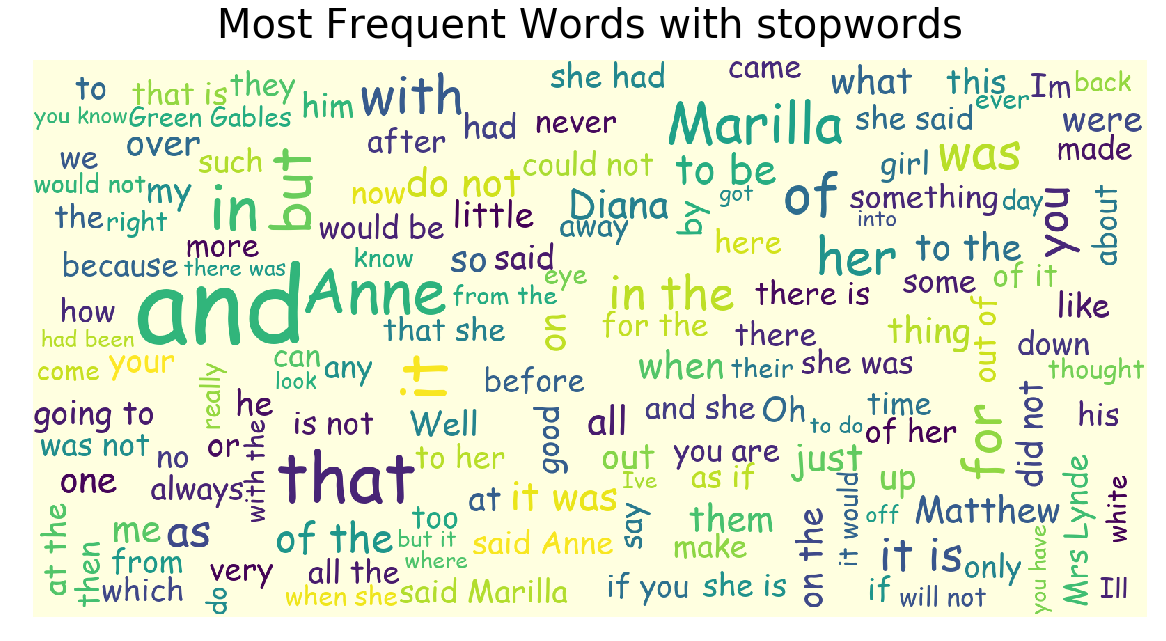

In [21]:
words(anne,s,'1',150)

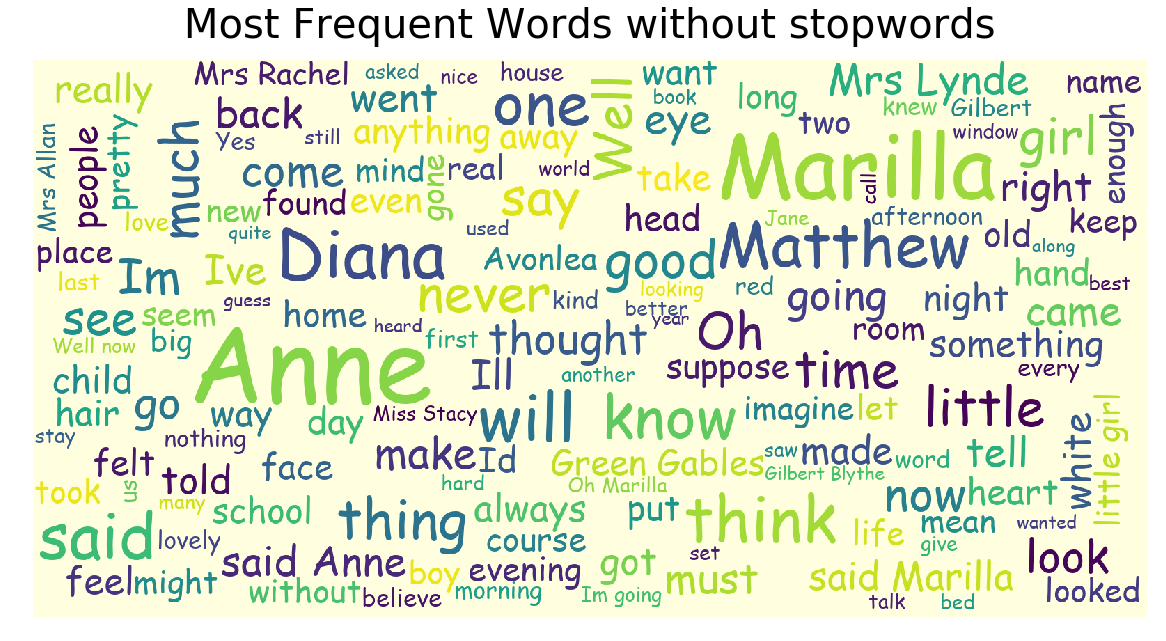

In [22]:
words(anne,STOPWORDS,'0',150)

## Stop Words

A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has
been programmed to ignore

In [23]:
# getting frequent 200 words with stopwords

from collections import Counter
Counter = Counter(anne_rtokens)

most_occur_stop = Counter.most_common(150) 
print(most_occur_stop) 

[('the', 3682), ('and', 3171), ('to', 3022), ('I', 2472), ('a', 2165), ('of', 1877), ('it', 1850), ('not', 1532), ('you', 1471), ('in', 1439), ('was', 1413), ('her', 1271), ('that', 1270), ('she', 1196), ('Anne', 1196), ('is', 1149), ('Marilla', 844), ('be', 821), ('had', 802), ('with', 772), ('as', 763), ('for', 711), ('said', 639), ('have', 630), ('at', 594), ('so', 589), ('do', 573), ('on', 562), ('me', 534), ('all', 514), ('would', 482), ('but', 481), ('up', 461), ('Diana', 414), ('Mrs', 402), ('he', 400), ('if', 387), ('out', 386), ('my', 370), ('But', 368), ('when', 367), ('Im', 362), ('Matthew', 358), ('will', 358), ('are', 354), ('did', 341), ('over', 335), ('just', 330), ('She', 323), ('were', 323), ('there', 316), ('think', 303), ('about', 298), ('can', 297), ('could', 295), ('like', 293), ('little', 290), ('them', 285), ('never', 278), ('very', 272), ('your', 271), ('one', 261), ('been', 259), ('know', 259), ('what', 251), ('they', 249), ('this', 248), ('Oh', 246), ('from', 

In [24]:
stop_words = set(stopwords.words('english')) 

In [25]:
def remove_stops(toks):
    
    '''function to remove stopwords
    from list of strings (here:novel)'''

    fil = [w for w in toks if not w in stop_words] 
    fil = [] 
  
    for w in toks: 
        if w not in stop_words: 
            fil.append(w)
    
    return fil

anne_rstoplist = remove_stops(anne_rtokens)
prophet_rstoplist = remove_stops(prophet_rtokens)

In [26]:
# getting frequent 200 words without stopwords

from collections import Counter
Counter = Counter(anne_rstoplist)

most_occur = Counter.most_common(150) 
print(most_occur) 

[('I', 2472), ('Anne', 1196), ('Marilla', 844), ('said', 639), ('would', 482), ('Diana', 414), ('Mrs', 402), ('But', 368), ('Im', 362), ('Matthew', 358), ('She', 323), ('think', 303), ('could', 295), ('like', 293), ('little', 290), ('never', 278), ('one', 261), ('know', 259), ('Oh', 246), ('It', 238), ('The', 228), ('good', 228), ('going', 226), ('go', 222), ('And', 220), ('much', 209), ('time', 176), ('girl', 174), ('see', 173), ('back', 168), ('ever', 165), ('must', 162), ('say', 160), ('You', 158), ('came', 155), ('went', 153), ('Ill', 151), ('Lynde', 150), ('thought', 150), ('Ive', 149), ('school', 147), ('Well', 144), ('things', 143), ('home', 141), ('eyes', 139), ('Miss', 138), ('well', 136), ('get', 136), ('Mr', 134), ('Barry', 132), ('Id', 129), ('says', 128), ('There', 123), ('got', 121), ('right', 121), ('tell', 120), ('made', 118), ('night', 117), ('really', 116), ('look', 115), ('thing', 115), ('hair', 115), ('come', 114), ('white', 113), ('told', 113), ('Gilbert', 113), ('

In [27]:
# Extracting common words from both list

f = list(set(most_occur) & set(most_occur_stop))
print(len(f))
print(f)

71
[('I', 2472), ('get', 136), ('long', 106), ('Ill', 151), ('Oh', 246), ('always', 106), ('came', 155), ('one', 261), ('Diana', 414), ('Id', 129), ('night', 117), ('But', 368), ('time', 176), ('home', 141), ('look', 115), ('come', 114), ('Anne', 1196), ('see', 173), ('Lynde', 150), ('thing', 115), ('Im', 362), ('must', 162), ('Marilla', 844), ('right', 121), ('say', 160), ('eyes', 139), ('felt', 106), ('much', 209), ('know', 259), ('And', 220), ('Well', 144), ('well', 136), ('tell', 120), ('Barry', 132), ('thought', 150), ('school', 147), ('go', 222), ('Miss', 138), ('like', 293), ('little', 290), ('Mr', 134), ('It', 238), ('good', 228), ('said', 639), ('think', 303), ('make', 109), ('You', 158), ('There', 123), ('Ive', 149), ('Mrs', 402), ('really', 116), ('The', 228), ('things', 143), ('got', 121), ('Gilbert', 113), ('white', 113), ('says', 128), ('going', 226), ('could', 295), ('hair', 115), ('ever', 165), ('old', 104), ('would', 482), ('went', 153), ('back', 168), ('made', 118), (

So, got to know that in frequent 200 words there are (200-112=88) stopwords

In [28]:
#calculating lenght of words in complete novel 'anne'
li = list(map(len, anne_removepunct.split()))

In [29]:
def countX(lst, x): 
    
    '''function to count frequencies
    of wordlenght in above prepared list'''
    
    count = 0
    for ele in lst: 
        if (ele == x): 
            count = count + 1
    return count 

In [30]:
def list_counts(lis):
    ''' function to create list with word lenght 
    and their counts in list'''

    counts=[]
    length=[]

    for x in range(1,30):
        if countX(lis,x)==0:
            break
        else:
            length.append(x)
            counts.append(countX(lis,x))
    
    return counts,length

In [31]:
counts_anne, lengths_anne = list_counts(li)

In [32]:
df = pd.DataFrame({'Length':lengths_anne,'Counts': counts_anne})
df

,Length,Counts
0,1,4725
1,2,18504
2,3,24922
3,4,22179
4,5,11895
5,6,7909
6,7,7278
7,8,3409
8,9,2083
9,10,1145


In [33]:
def freq_dist(x,y,color,k):
    plt.figure(figsize = (14,8))
    plt.bar(x,y,color=color,alpha=0.6)
    

    plt.title("Frequency Distribution of "+ k, fontsize=18)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel("Lenght of words",fontsize=12)
    plt.ylabel("Number of words",fontsize=12)

    plt.tight_layout()
    plt.show()

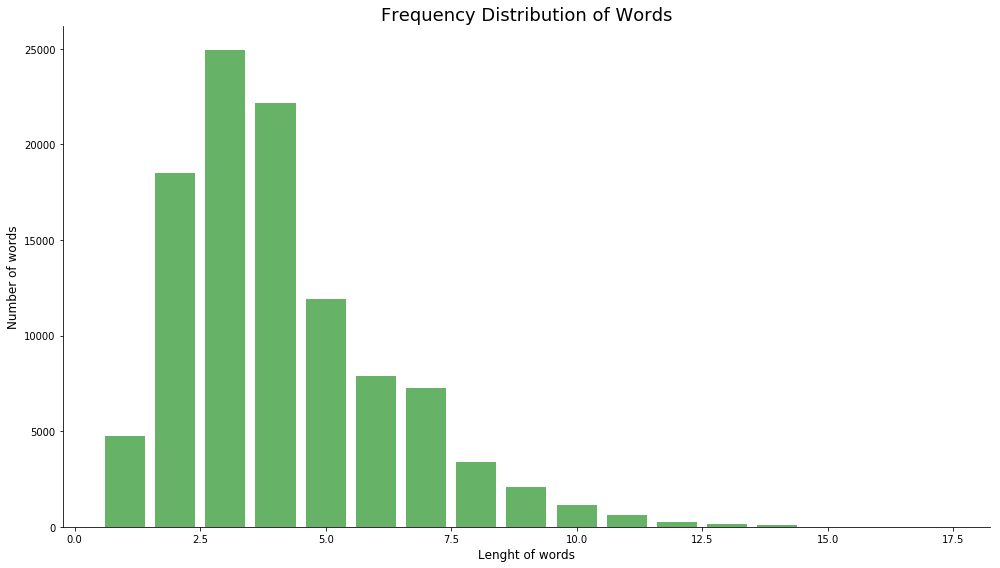

In [34]:
freq_dist(df['Length'],df['Counts'],color='green',k='Words')

In [35]:
df['Length'].corr(df['Counts'])
# as expected inversely correlated 

-0.7648214510793667

In [36]:
def pos_tags(toks):
    tagged = nltk.pos_tag(toks)

    q=[]

    for p in tagged:
        q.append(p[1])
    
    new=list(set(q))
    
    tag=[]
    cnt=[]

    for x in new:
        tag.append(x)
        cnt.append(countX(q,x))
        
    return tag,cnt

In [37]:
tags, tag_counts = pos_tags(anne_rtokens)

In [38]:
df2 = pd.DataFrame({'Tags':tags,'Counts': tag_counts})
df2 = df2.sort_values(by='Counts',ascending=False).reset_index()
df2.drop('index',axis=1,inplace=True)

In [39]:
df2.sample(10)

,Tags,Counts
2,PRP,10238
20,WP,503
29,RBS,39
16,VBZ,1974
19,WRB,751
6,VBD,7282
17,MD,1951
18,RP,870
25,PDT,210
30,UH,17


# What is Part of Speech Tagging ?


Part of Speech Tagging is the process of associating each word in a piece of text with a particular tag, which represents the type of word it is, i.e. proper noun, comparative adjective, interjection etc. For example, the word “Michael” is a singular proper noun, so its PoS tag would be NNP,
which is the NLTK tag for singular proper noun. Another example is the word “smartest”. It is a
superlative adjective, so its PoS tag would be JJS, which is the NLTK tag for superlative adjective.

**Here are all the PoS tags supported by NLTK :**

* CC coordinating conjunction
* CD cardinal digit
* DT determiner
* EX existential there (like: “there is” . . . think of it like “there exists”)
* FW foreign word
* IN preposition/subordinating conjunction
* JJ adjective ‘big’
* JJR adjective, comparative ‘bigger’
* JJS adjective, superlative ‘biggest’
* LS list marker
* MD modal could, will
* NN noun, singular ‘desk’
* NNS noun plural ‘desks’
* NNP proper noun, singular ‘Harrison’
* NNPS proper noun, plural ‘Americans’
* PDT predeterminer ‘all the kids’
* POS possessive ending parent’s
* PRP personal pronoun I, he, she
* PRP' possessive pronoun my, his, hers
* RB adverb very, silently,
* RBR adverb, comparative better
* RBS adverb, superlative best
* RP particle give up
* TO to go ‘to’ the store.
* UH interjection, errrrrrrrm
* VB verb, base form take
* VBD verb, past tense took
* VBG verb, gerund/present participle taking
* VBN verb, past participle taken
* VBP verb, sing. present, non-3d take
* VBZ verb, 3rd person sing. present takes
* WDT wh-determiner which
* WP wh-pronoun who, what
* WP' possessive wh-pronoun whose
* WRB wh-abverb where, when

' Represent $

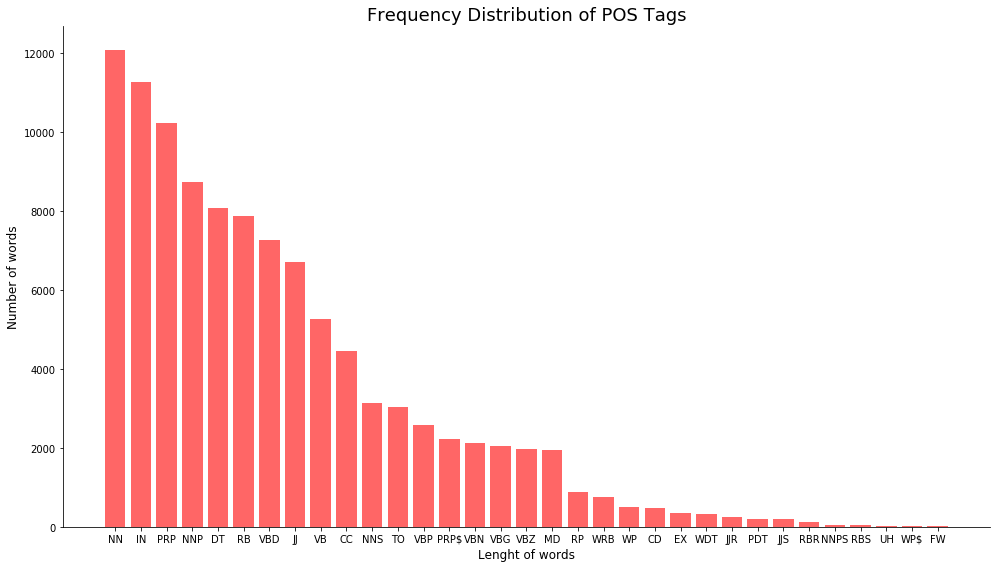

In [40]:
freq_dist(df2['Tags'],df2['Counts'],color='red',k='POS Tags')

# Novel "Prophet"

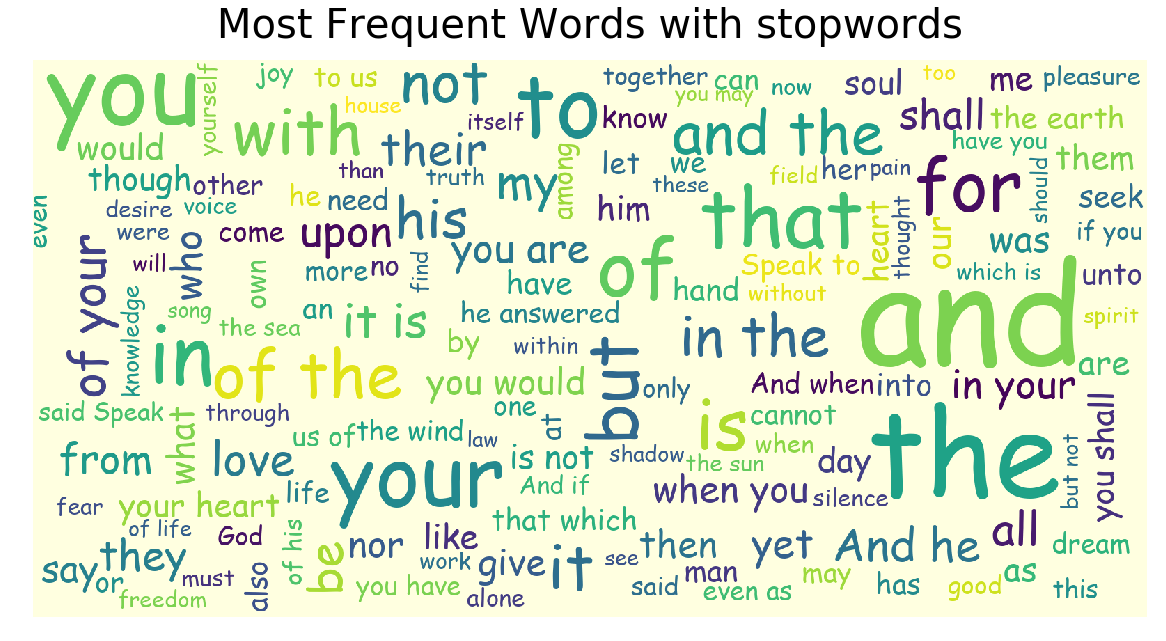

In [41]:
words(prophet,s,'1',200)

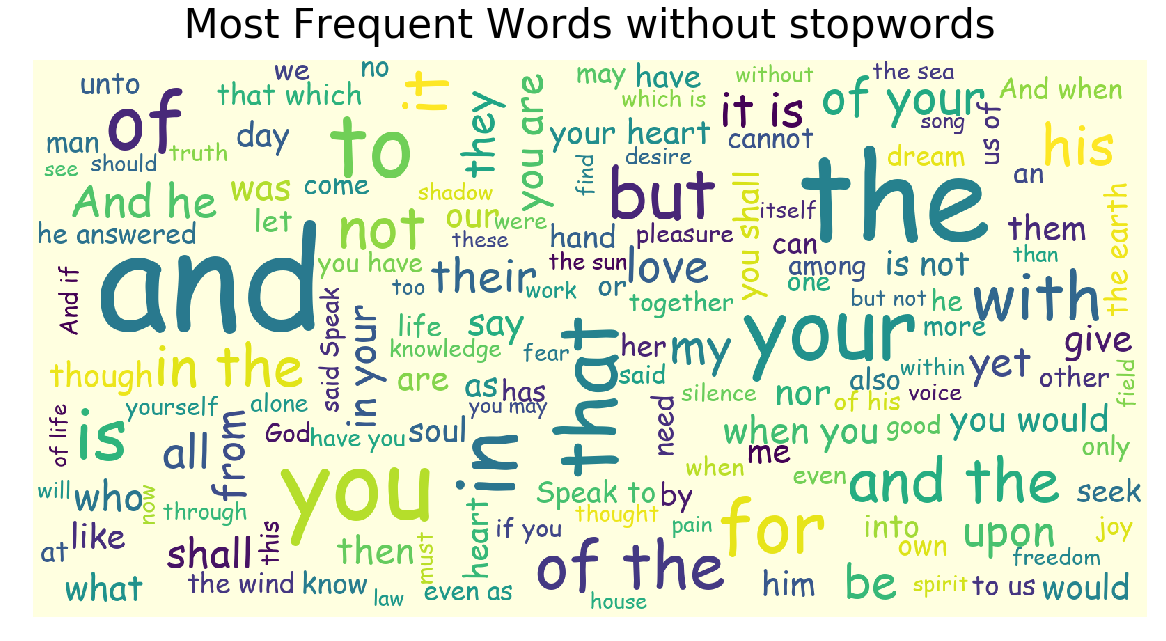

In [42]:
words(prophet,s,STOPWORDS,200)

In [43]:
# getting frequent 200 words with stopwords

from collections import Counter
Counter = Counter(prophet_rtokens)

most_occur_stop = Counter.most_common(150) 
print(most_occur_stop) 

[('the', 783), ('and', 462), ('you', 418), ('of', 400), ('your', 317), ('in', 295), ('And', 269), ('is', 237), ('to', 233), ('a', 220), ('that', 192), ('not', 187), ('shall', 108), ('I', 108), ('with', 105), ('it', 105), ('are', 102), ('he', 100), ('his', 95), ('but', 95), ('have', 77), ('for', 75), ('be', 75), ('who', 68), ('when', 67), ('would', 59), ('my', 58), ('For', 58), ('But', 55), ('heart', 52), ('all', 52), ('their', 51), ('us', 51), ('as', 50), ('can', 50), ('which', 49), ('upon', 48), ('said', 48), ('love', 45), ('from', 42), ('You', 39), ('him', 38), ('they', 38), ('may', 35), ('if', 35), ('nor', 34), ('It', 33), ('what', 33), ('say', 33), ('was', 32), ('its', 32), ('our', 32), ('own', 31), ('into', 31), ('life', 31), ('them', 30), ('me', 30), ('one', 30), ('give', 29), ('even', 29), ('has', 28), ('earth', 28), ('let', 26), ('unto', 25), ('spirit', 25), ('The', 25), ('though', 25), ('soul', 24), ('an', 24), ('like', 24), ('by', 24), ('man', 24), ('her', 23), ('wind', 23), 

In [44]:
prophet_rstoplist = remove_stops(prophet_rtokens)

In [45]:
# getting frequent 200 words without stopwords

from collections import Counter
Counter = Counter(prophet_rstoplist)

most_occur = Counter.most_common(150) 
print(most_occur) 

[('And', 269), ('shall', 108), ('I', 108), ('would', 59), ('For', 58), ('But', 55), ('heart', 52), ('us', 51), ('upon', 48), ('said', 48), ('love', 45), ('You', 39), ('may', 35), ('It', 33), ('say', 33), ('life', 31), ('one', 30), ('give', 29), ('even', 29), ('earth', 28), ('let', 26), ('unto', 25), ('spirit', 25), ('The', 25), ('though', 25), ('soul', 24), ('like', 24), ('man', 24), ('wind', 23), ('also', 23), ('answered', 23), ('seek', 22), ('yet', 22), ('day', 21), ('Speak', 21), ('among', 20), ('Yet', 19), ('things', 19), ('another', 19), ('God', 19), ('city', 18), ('sea', 18), ('saying', 18), ('together', 18), ('joy', 17), ('come', 17), ('He', 17), ('see', 17), ('good', 17), ('Then', 16), ('must', 16), ('alone', 16), ('truth', 16), ('know', 16), ('house', 16), ('within', 15), ('sun', 15), ('hand', 15), ('greater', 15), ('knowledge', 15), ('fear', 15), ('Your', 15), ('self', 15), ('without', 14), ('days', 14), ('words', 14), ('pain', 13), ('night', 13), ('freedom', 13), ('speak', 1

In [46]:
# Extracting common words from both list

f = list(set(most_occur) & set(most_occur_stop))
print(len(f))
print(f)

81
[('seek', 22), ('pain', 13), ('would', 59), ('God', 19), ('say', 33), ('self', 15), ('let', 26), ('needs', 12), ('voice', 12), ('things', 19), ('longing', 11), ('Speak', 21), ('yet', 22), ('without', 14), ('may', 35), ('unto', 25), ('You', 39), ('though', 25), ('love', 45), ('greater', 15), ('What', 12), ('sea', 18), ('day', 21), ('soul', 24), ('one', 30), ('like', 24), ('know', 16), ('It', 33), ('even', 29), ('among', 20), ('within', 15), ('house', 16), ('man', 24), ('I', 108), ('He', 17), ('joy', 17), ('us', 51), ('came', 11), ('speak', 13), ('earth', 28), ('good', 17), ('children', 11), ('work', 12), ('When', 13), ('rise', 12), ('freedom', 13), ('For', 58), ('fear', 15), ('hands', 11), ('life', 31), ('answered', 23), ('come', 17), ('The', 25), ('ship', 12), ('Then', 16), ('together', 18), ('said', 48), ('words', 14), ('And', 269), ('night', 13), ('heart', 52), ('saying', 18), ('days', 14), ('give', 29), ('But', 55), ('alone', 16), ('hand', 15), ('see', 17), ('spirit', 25), ('trut

In [47]:
li2 = list(map(len, prophet_removepunct.split()))

In [48]:
counts_prophet, lengths_prophet = list_counts(li2)

In [49]:
df_p1 = pd.DataFrame({'Length':lengths_prophet,'Counts': counts_prophet})
df_p1

,Length,Counts
0,1,335
1,2,1962
2,3,3594
3,4,2580
4,5,1509
5,6,1013
6,7,576
7,8,368
8,9,251
9,10,72


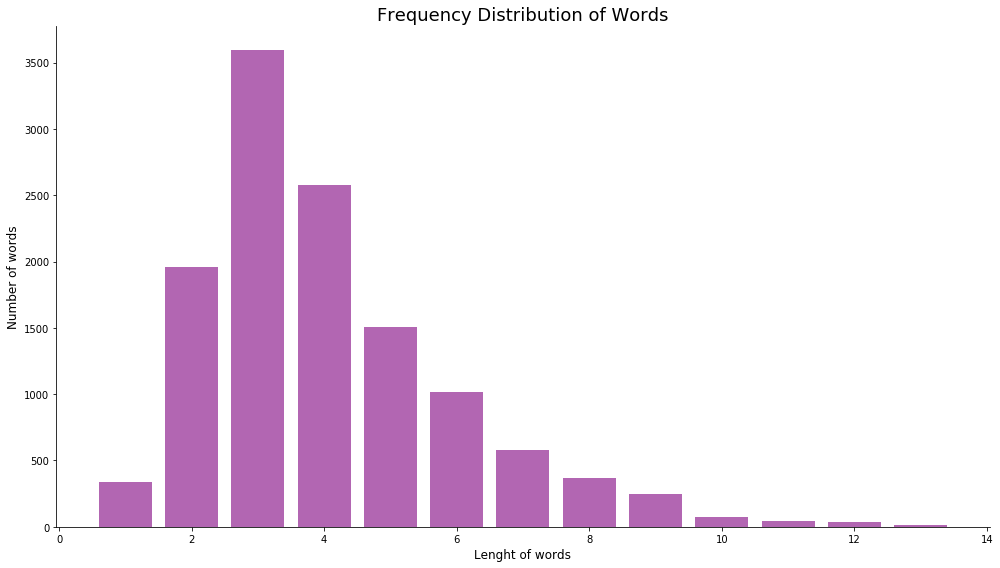

In [50]:
freq_dist(df_p1['Length'],df_p1['Counts'],color='purple',k='Words')

In [51]:
prophet_tags, protag_counts = pos_tags(prophet_rtokens)

In [52]:
df_p2 = pd.DataFrame({'Tags':prophet_tags,'Counts': protag_counts})
df_p2 = df_p2.sort_values(by='Counts',ascending=False).reset_index()
df_p2.drop('index',axis=1,inplace=True)

In [53]:
df2

,Tags,Counts
0,NN,12082
1,IN,11266
2,PRP,10238
3,NNP,8752
4,DT,8091
5,RB,7884
6,VBD,7282
7,JJ,6718
8,VB,5267
9,CC,4448


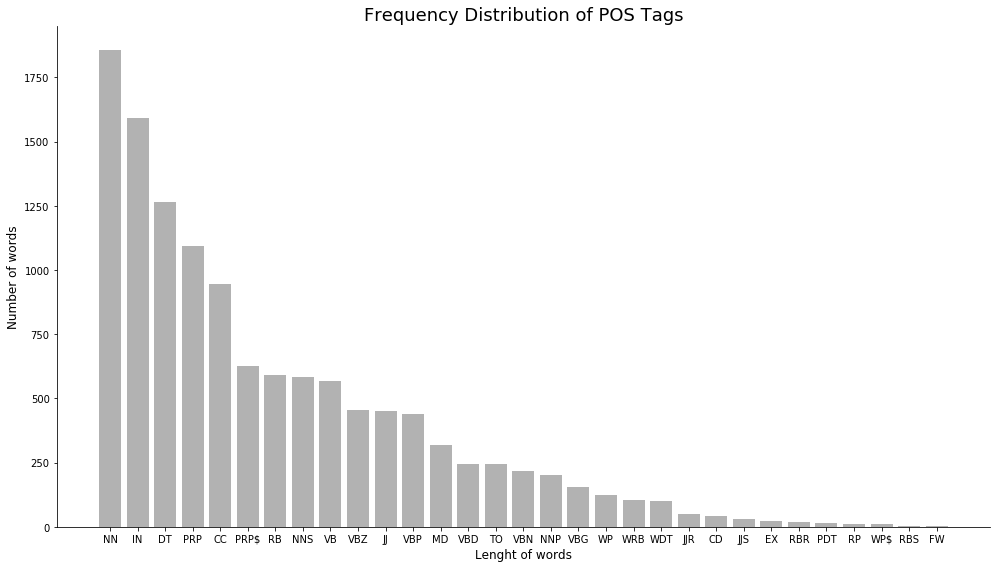

In [54]:
freq_dist(df_p2['Tags'],df_p2['Counts'],color='grey',k='POS Tags')

# Project Part 2

In [55]:
total_nouns = ['act', 'animal', 'artifact', 'attribute', 'body','cognition', 'communication', 'event', 'feeling', 'food',
               'group','location', 'motive', 'object', 'person','phenomenon', 'plant', 'possession', 'process', 'quantity',
               'relation', 'shape', 'state', 'substance','time']

len(total_nouns)

25

## Word Sense Disambiguation

word sense disambiguation (WSD) is the problem of determining which "sense" (meaning) of a word is activated by the use of the word in a particular context

In [56]:
def disambi(sent_tokens):
    
    '''Function for disambiguation of meanings like volume(used as book, water)'''
    
    new_list=[]

    for i in sent_tokens:
        new_list.append(disambiguate(i))
        
    jee=[]

    for j in new_list:
        for k in j:
            jee.append(k[1])
    
    res = list(filter(None, jee)) 
    
    n=[]

    for i in res:
        n.append(i.name())
        
    return res,n

In [57]:
filter_toks, tok_name = disambi(anne_sents)

In [58]:
def if_noun(category,toks):
    
    '''Function for getting noun category from
    wordnet tags'''
    
    noun_cat=[]
    
    for syn in toks:
        if category in syn.lexname():
            names = syn.name()
            noun_cat.append(names[:-5])
        
    return noun_cat

In [59]:
def cat_list(cat,types,toks):
    
    '''Getting counts and frquencies of noun/verb and 
    storing them in a list'''
    
    if types=='1':
        noun_list = if_noun(cat,toks)
        noun_list = [x.lower() for x in noun_list]
        count_nouns.append(len(noun_list))
        noun_list = unique(noun_list)
        len_nouns.append(len(noun_list))
        
        return noun_list
    
    
    else:
        verb_list = if_verb(cat,toks)
        verb_list = [x.lower() for x in verb_list]
        count_verbs.append(len(verb_list))
        verb_list = unique(verb_list)
        len_verbs.append(len(verb_list))
        
        return verb_list

In [60]:
len_nouns=[]
count_nouns=[]

for i in total_nouns:
    cat_list(i,'1',filter_toks)

In [61]:
print(len_nouns)
print(count_nouns)

[1084, 65, 520, 242, 157, 321, 538, 114, 82, 80, 120, 104, 6, 90, 376, 37, 69, 135, 14, 83, 15, 25, 147, 55, 114]
[5377, 216, 2844, 1128, 879, 2991, 5115, 452, 297, 362, 702, 922, 15, 519, 4135, 124, 399, 664, 36, 376, 77, 77, 622, 304, 1121]


In [62]:
def barsplt(x,y,color,typ):
    
    '''Function for creating bar plot'''
    
    plt.figure(figsize=(16,7))
    plt.bar(x, y, alpha=0.6,color=color)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.xlabel(typ,fontsize=14)
    plt.xticks(rotation=70)
    plt.ylabel('Counts', fontsize=14)
    plt.title('Count of '+typ+ ' in Novel',fontsize=18)

    plt.show()

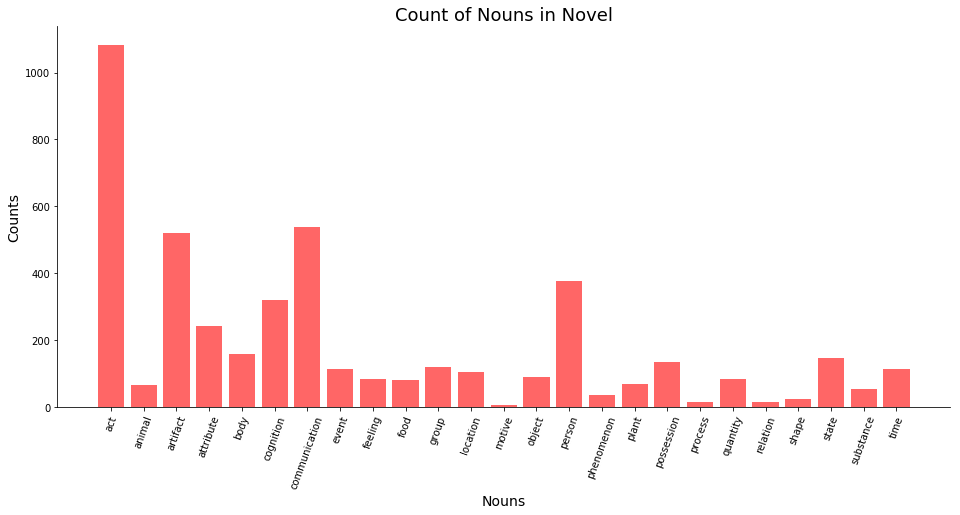

In [63]:
barsplt(total_nouns, len_nouns,'red','Nouns')

In [64]:
total_verbs = ['body','change','cognition','communication','competition','consumption','contact','creation','emotion'
              ,'motion','perception','social','stative','weather','possession']

In [65]:
def if_verb(category,toks):

    verb_cat=[]
    
    for syn in toks:
        if category in syn.lexname():
            verb_cat.append(syn.name())
        
    return verb_cat

In [66]:
len_verbs=[]
count_verbs=[]

for i in total_verbs:
    cat_list(i,'2',filter_toks)

In [67]:
print(count_verbs)
print(len_verbs)

[879, 1247, 2991, 5115, 194, 277, 1222, 407, 644, 2024, 918, 734, 1292, 38, 664]
[170, 264, 410, 658, 51, 48, 262, 90, 86, 333, 108, 164, 192, 15, 164]


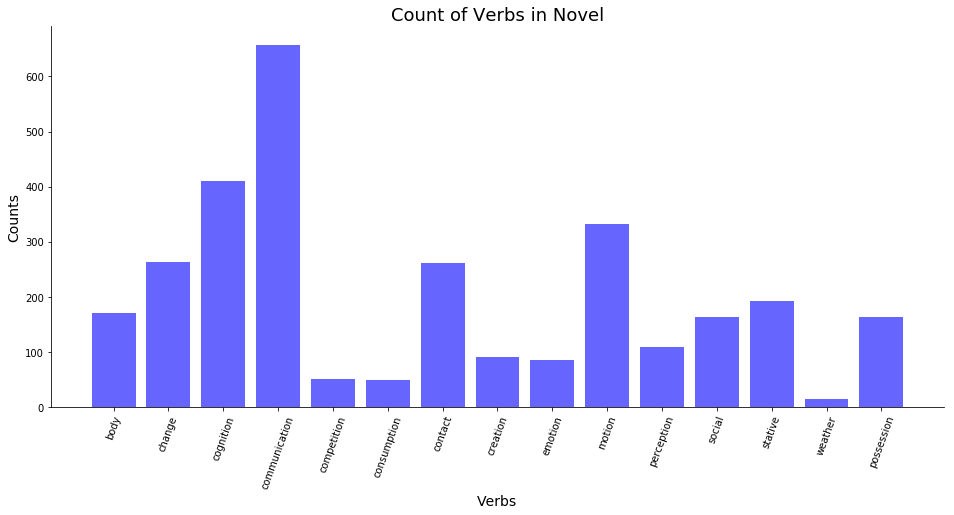

In [68]:
barsplt(total_verbs, len_verbs,'blue','Verbs')

# Named Entity Recognition

In [69]:
ne_tree = ne_chunk(pos_tag(word_tokenize(anne)))

In [70]:
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

In [71]:
from collections import Counter

In [72]:
doc = nlp(anne)

In [73]:
tags = [(X.text, X.label_) for X in doc.ents]

In [74]:
persons,orgs,locations,gpe,vehicle,facility=[],[],[],[],[],[]

for i in tags:
    if i[1] == 'PERSON':
        persons.append(i[0])
    elif i[1] == 'ORG':
        orgs.append(i[0])
    elif i[1] == 'LOC':
        locations.append(i[0])
    elif i[1]  =='GPE':
        gpe.append(i[0])
    elif i[1] == 'VEH':
        vehicle.append(i[0])
    elif i[1] == 'FAC':
        facility.append(i[0])
        
persons,orgs,locations=unique(persons),unique(orgs),unique(locations)

In [75]:
pls=' '.join(anne_sents[1:20])

In [76]:
toks = word_tokenize(pls)

In [77]:
displacy.render(nlp(str(' '.join(anne_sents[1:20]))), jupyter=True, style='ent')

`MRS. Rachel Lynde`**[Person]** lived just where the `Avonlea`**[GPE]** main road dipped down into a little hollow, fringed with alders and ladies eardrops and traversed by a brook that had its source away back in the woods of the `old Cuthbert place` **[Place]**; it was reputed to be an intricate, headlong brook in its earlier course through those woods, with dark secrets of pool and cascade; but by the time it reached `Lynde Hollow`**[Person]** it was a quiet, well-conducted little stream, for not even a brook could run past `Mrs. Rachel Lynde`**[Person]** door without due regard for decency and decorum; it probably was conscious that `Mrs. Rachel`**[Person]** was sitting at her window, keeping a sharp eye on everything that passed, from brooks and children up, and that if she noticed anything odd or out of place she would never rest until she had ferreted out the whys and wherefores thereof.  There are plenty of people in `Avonlea`**[GPE]** and out of it, who can attend closely to their neighbor business by dint of neglecting their own; but `Mrs. Rachel Lynde`**[Person]** was one of those capable creatures who can manage their own concerns and those of other folks into the bargain. She was a notable housewife; her work was always done and well done; she "ran" the `Sewing Circle`**[Org]**, helped run the `Sunday-school`**[Org]**, and was the strongest prop of the `Church Aid Society`**[Org]** and `Foreign Missions Auxiliary`**[Org]**. Yet with all this `Mrs. Rachel`**[Person]** found abundant time to sit for hours at her kitchen window, knitting "cotton warp" quilts--she had knitted sixteen of them, as `Avonlea`**[GPE]** housekeepers were wont to tell in awed voices--and keeping a sharp eye on the main road that crossed the hollow and wound up the steep red hill beyond. Since `Avonlea`**[GPE]** occupied a little triangular peninsula jutting out into the `Gulf of St. Lawrence`**[LOC]** with water on two sides of it, anybody who went out of it or into it had to pass over that hill road and so run the unseen gauntlet of `Mrs. Rachel`**[GPE]** all-seeing eye.  She was sitting there one afternoon in early June. The sun was coming in at the window warm and bright; the orchard on the slope below the house was in a bridal flush of pinky-white bloom, hummed over by a myriad of bees. `Thomas Lynde`**[Person]**--a meek little man whom `Avonlea`**[GPE]** people called "`Rachel Lynde`**[Person]** husband"--was sowing his late turnip seed on the hill field beyond the barn; and `Matthew Cuthbert`**[Person]** ought to have been sowing his on the big red brook field away over by `Green Gables`**[ORG]**. `Mrs. Rachel`**[Person]** knew that he ought because she had heard him tell `Peter Morrison`**[Person]** the evening before in `William J. Blair store` **[ORG]** over at `Carmody`**[GPE]** that he meant to sow his turnip seed the next afternoon. `Peter`**[Person]** had asked him, of course, for `Matthew Cuthbert`**[Person]** had never been known to volunteer information about anything in his whole life.  And yet here was `Matthew Cuthbert`**[Person]**], at half-past three on the afternoon of a busy day, placidly driving over the hollow and up the hill; moreover, he wore a white collar and his best suit of clothes, which was plain proof that he was going out of `Avonlea`**[GPE]**; and he had the buggy and the sorrel mare, which betokened that he was going a considerable distance. Now, where was `Matthew Cuthbert`**[Person]** going and why was he going there?  Had it been any other man in `Avonlea`**[GPE]**, `Mrs. Rachel`**[Person]**, deftly putting this and that together, might have given a pretty good guess as to both questions. But `Matthew`**[Person]** so rarely went from home that it must be something pressing and unusual which was taking him; he was the shyest man alive and hated to have to go among strangers or to any place where he might have to talk. `Matthew`**[Person]**, dressed up with a white collar and driving in a buggy, was something that did not happen often. `Mrs. Rachel`**[Person]**, ponder as she might, could make nothing of it and her afternoon enjoyment was spoiled.  "Ill just step over to `Green Gables`**[ORG]** after tea and find out from `Marilla`**[Person]** where he is gone and why," the worthy woman finally concluded. "He does not generally go to town this time of year and he -never- visits; if he would run out of turnip seed he would not dress up and take the buggy to go for more; he was not driving fast enough to be going for a doctor. Yet something must have happened since last night to start him off.

## Performance Measure

In [78]:
True_positive = 31
False_positive = 5
False_negative = 2

In [79]:
Precision = True_positive / (True_positive + False_positive)
Recall = True_positive / (True_positive + False_negative)

In [80]:
print(Precision)
print(Recall)

0.8611111111111112
0.9393939393939394


In [81]:
F1 = 2*Precision*Recall/(Precision+Recall)
print(F1)

0.8985507246376813


# For Novel 2

In [82]:
prophet_toks, tok_prophet = disambi(prophet_sents)

In [83]:
len_nouns=[]
count_nouns=[]

for i in total_nouns:
    cat_list(i,'1',prophet_toks)

In [84]:
print(len_nouns)
print(count_nouns)

[299, 22, 141, 79, 50, 90, 135, 36, 32, 14, 38, 35, 2, 31, 124, 17, 20, 40, 9, 13, 4, 9, 61, 18, 33]
[715, 48, 347, 212, 96, 303, 491, 49, 88, 28, 122, 52, 2, 101, 289, 53, 69, 104, 15, 49, 12, 15, 135, 78, 140]


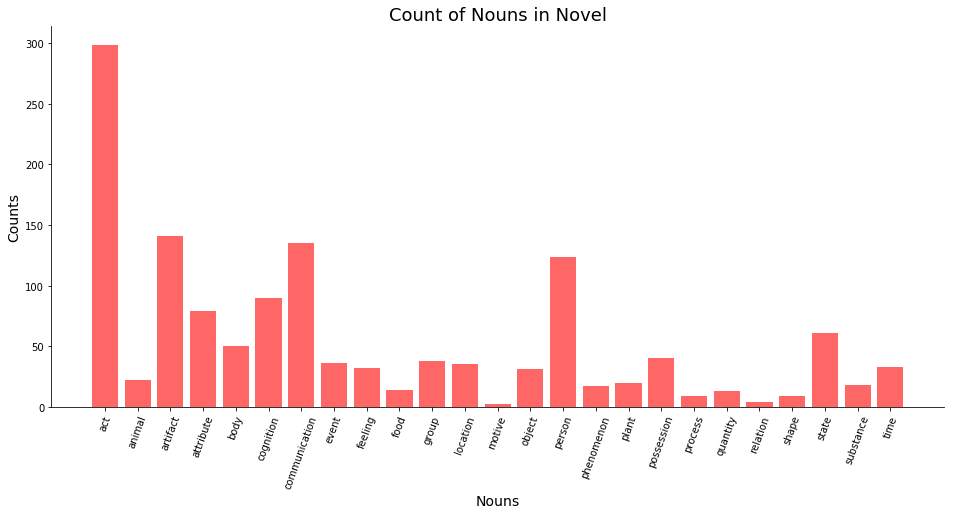

In [85]:
barsplt(total_nouns, len_nouns,'red','Nouns')

In [86]:
len_verbs=[]
count_verbs=[]

for i in total_verbs:
    cat_list(i,'2',prophet_toks)

In [87]:
print(count_verbs)
print(len_verbs)

[96, 103, 303, 491, 23, 40, 186, 34, 67, 210, 87, 100, 145, 9, 104]
[51, 67, 103, 155, 15, 16, 74, 17, 23, 97, 28, 42, 59, 6, 44]


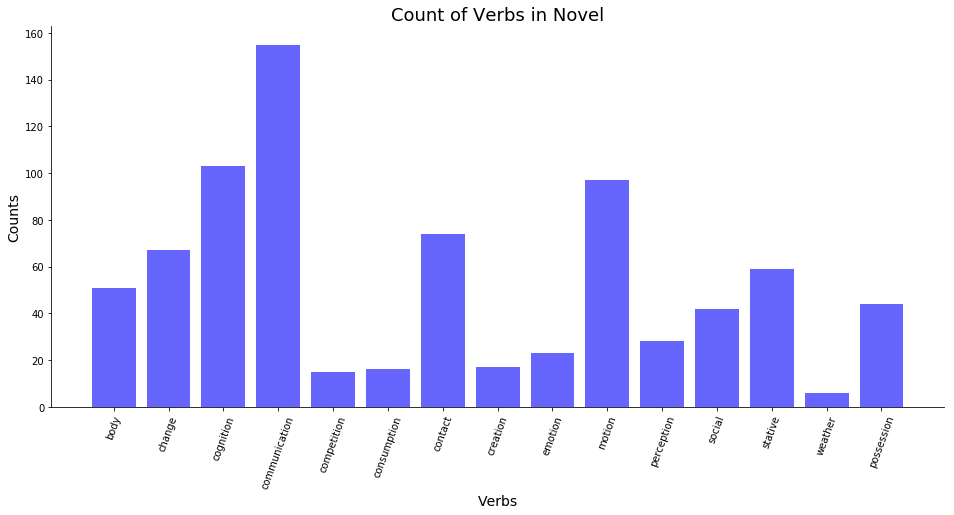

In [88]:
barsplt(total_verbs, len_verbs,'blue','Verbs')

In [89]:
displacy.render(nlp(str(' '.join(prophet_sents[100:120]))), jupyter=True, style='ent')